In [129]:
import pandas as pd
import datetime

fee = 1.5
delta = 0.95
account_size = 10000
stop_loss = 500

trading_days_in_year = 252

start_date = datetime.date(year=2006, month=6, day=13)
end_date = datetime.date(year=2018, month=12, day=20)
validation_date = datetime.date(year=2016, month=1, day=1)

gold = pd.read_csv('data/gold_daily.csv', index_col='Date')
gold_cot = pd.read_csv('data/gold_cot.csv', index_col='Date')

corn = pd.read_csv('data/corn_daily.csv', index_col='Date')
corn_cot = pd.read_csv('data/corn_cot.csv', index_col='Date')

coffee = pd.read_csv('data/coffee_daily.csv', index_col='Date')
coffee_cot = pd.read_csv('data/coffee_cot.csv', index_col='Date')

In [130]:
gold.index = pd.DatetimeIndex(data=gold.index)
gold_cot.index = pd.DatetimeIndex(data=gold_cot.index)

corn.index = pd.DatetimeIndex(data=corn.index)
corn_cot.index = pd.DatetimeIndex(data=corn_cot.index)

coffee.index = pd.DatetimeIndex(data=coffee.index)
coffee_cot.index = pd.DatetimeIndex(data=coffee_cot.index)

In [131]:
gold = gold.sort_index(kind='mergesort')
gold_cot = gold_cot.sort_index(kind='mergesort')
corn = corn.sort_index(kind='mergesort')
corn_cot = corn_cot.sort_index(kind='mergesort')
coffee = coffee.sort_index(kind='mergesort')
coffee_cot = coffee_cot.sort_index(kind='mergesort')

In [132]:
gold_cot.head(10)

,Open Interest,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Swap Dealer Longs,Swap Dealer Shorts,Swap Dealer Spreads,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
Date,,,,,,,,,,,,,,,,
2006-06-13,382474.0,42587.0,128892.0,19370.0,66611.0,22998.0,103211.0,30916.0,46704.0,33230.0,10656.0,58412.0,326513.0,365190.0,55961.0,17284.0
2006-06-20,390281.0,47440.0,126992.0,22404.0,64682.0,25806.0,94632.0,30963.0,48730.0,32947.0,11142.0,64458.0,336417.0,372774.0,53864.0,17507.0
2006-06-27,384321.0,48449.0,121890.0,22425.0,62640.0,25151.0,91042.0,32287.0,49614.0,31307.0,11386.0,59762.0,327749.0,362729.0,56572.0,21592.0
2006-07-03,392868.0,48087.0,122568.0,22720.0,69714.0,26352.0,92545.0,30452.0,50821.0,32874.0,8677.0,63514.0,336914.0,372098.0,55955.0,20771.0
2006-07-11,427008.0,54509.0,130618.0,21840.0,79217.0,28805.0,104213.0,27624.0,54922.0,33165.0,11194.0,70944.0,368398.0,403323.0,58611.0,23685.0
2006-07-18,443519.0,49863.0,131166.0,21681.0,83183.0,33352.0,107413.0,24296.0,62395.0,31760.0,9442.0,74272.0,380737.0,418105.0,62782.0,25414.0
2006-07-25,432413.0,52859.0,133290.0,22956.0,85604.0,28832.0,99087.0,22386.0,64810.0,29740.0,6244.0,73980.0,372265.0,415146.0,60148.0,17266.0
2006-08-01,394609.0,45161.0,135988.0,21250.0,73244.0,23643.0,99330.0,24391.0,54618.0,32195.0,4758.0,57618.0,333815.0,374260.0,60795.0,20350.0
2006-08-08,402899.0,46203.0,142240.0,20703.0,72061.0,24259.0,104600.0,24271.0,57785.0,33123.0,6489.0,57914.0,344587.0,385020.0,58312.0,17880.0


In [133]:
def percentage_from_max(sr):
    mx = sr.max()
    mn = sr.min()
    return (sr[-1]-mn)/(mx-mn)

def max_positions_percentage(df):
    df['Prod_net_position'] = df['Producer/Merchant/Processor/User Longs'] - df['Producer/Merchant/Processor/User Shorts']
    df['Prod_net_position_perc'] = df.rolling('730d')['Prod_net_position'].apply(percentage_from_max, raw=False)
    df['Money_manager_net_position'] = df['Money Manager Longs'] - df['Money Manager Shorts']
    df['Money_manager_net_position_perc'] = df.rolling('730d')['Money_manager_net_position'].apply(percentage_from_max, raw=False)
    df = df[['Prod_net_position_perc', 'Money_manager_net_position_perc']]
    return df

In [134]:
gold_cot = max_positions_percentage(gold_cot)
corn_cot = max_positions_percentage(corn_cot)
coffee_cot = max_positions_percentage(coffee_cot)

In [633]:
# code from stockstats pypy package
def get_wr(df, n_days):
    """ Williams Overbought/Oversold Index
    WMS=[(Hn—Ct)/(Hn—Ln)] ×100
    Ct - the close price
    Hn - N days high
    Ln - N days low
    :param df: data
    :param n_days: N days
    :return: None
    """
    n_days = int(n_days)
    ln = df['Low'].rolling(min_periods=1, window=n_days,
                           center=False).min()
    hn = df['High'].rolling(min_periods=1, window=n_days,
                            center=False).max()
    column_name = 'wr_{}'.format(n_days)
    df[column_name] = (hn - df['close']) / (hn - ln) * 100

In [530]:
def create_labels(df, treshold):
    global fee, delta, stop_loss
    def calculate_target(row):
        # print(type(row))
        # print(row.shape)
        volatility = (row['Settle']-row['Open'])*delta
        if abs(volatility) > fee + treshold:
            if volatility > 0:
                if row['Open'] - row['Low'] > stop_loss:
                    return 0
                else:
                    return 1
            else:
                if row['High'] - row['Open'] > stop_loss:
                    return 0
                else:
                    return (-1)
        else:
            return 0
    ans_df = pd.DataFrame([])
    # ans_df = df.copy()
    # ans_df['target'] = df['Settle'] - df['Open']
    ans_df['target'] = df.apply(calculate_target, axis=1)
    ans_df.target = ans_df.target.shift(-1)
    return ans_df


def create_trade_outcomes(df, contracts):
    global fee, treshold, delta
    ans_df = pd.DataFrame([])
    ans_df['gains'] = (df['Settle'] - df['Open'])*0.95*contracts
    ans_df = pd.concat([ans_df, df[['Open', 'High', 'Low', 'Settle']]*contracts], axis=1)
    return ans_df

In [531]:
gold_gains = create_trade_outcomes(gold, 100)
gold_gains.head(5)

,gains,Open,High,Low,Settle
Date,,,,,
1996-01-02,342.0,38830.0,39200.0,38800.0,39190.0
1996-01-03,361.0,39240.0,39630.0,39220.0,39620.0
1996-01-04,95.0,39440.0,39580.0,39410.0,39540.0
1996-01-05,-123.5,39780.0,39920.0,39620.0,39650.0
1996-01-09,104.5,39580.0,39710.0,39480.0,39690.0


In [538]:
treshold = 300
gold_label = create_labels(gold_gains, treshold)
gold['target'] = gold_label.target
tot, trade = gold.shape[0], gold[gold.target != 0].shape[0]
print(tot, trade, float(trade/tot))

5781 2006 0.3469987891368275


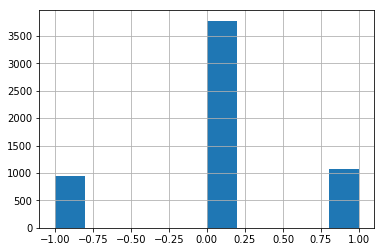

In [539]:
gold['target'].hist()

In [540]:
# Corn Contract has 5000 bushels contract is in cents therefore 50 contracts are producing desired values
corn_gains = create_trade_outcomes(corn, 50)
corn_gains.head(5)

,gains,Open,High,Low,Settle
Date,,,,,
1996-01-02,106.875,18550.0,18762.5,18512.5,18662.5
1996-01-03,47.500,18650.0,18725.0,18512.5,18700.0
1996-01-04,-213.750,18675.0,18687.5,18250.0,18450.0
1996-01-05,-11.875,18337.5,18450.0,18275.0,18325.0
1996-01-08,-190.000,18225.0,18225.0,18000.0,18025.0


5790 1895 0.32728842832469773


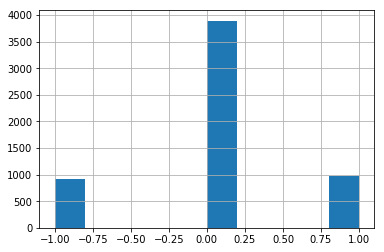

In [542]:
treshold = 200

corn_label = create_labels(corn_gains, treshold)
corn['target'] = corn_label.target
tot, trade = corn.shape[0], corn[corn.target != 0].shape[0]
print(tot, trade, float(trade/tot))

corn.target.hist()

In [546]:
# coffee contract size is 37,500 pounds price is in cents per pound
coffee_gains = create_trade_outcomes(coffee, 375)
coffee_gains.head(5)

,gains,Open,High,Low,Settle
Date,,,,,
1996-01-02,-480.9375,34725.0,35550.00,34162.5,34218.75
1996-01-03,1015.3125,34087.5,35400.00,33900.0,35156.25
1996-01-04,1727.8125,34875.0,36787.50,34875.0,36693.75
1996-01-05,-445.3125,36562.5,37293.75,35925.0,36093.75
1996-01-10,890.6250,35775.0,36843.75,35550.0,36712.50


5752 1963 0.34127260083449235


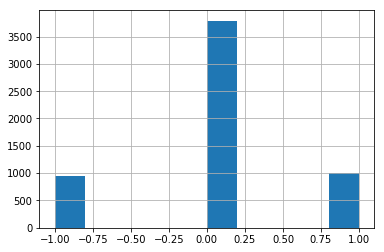

In [547]:
treshold = 300

coffee_label = create_labels(coffee_gains, treshold)
coffee['target'] = coffee_label.target
tot, trade = coffee.shape[0], coffee[coffee.target != 0].shape[0]
print(tot, trade, float(trade/tot))

coffee.target.hist()

In [548]:
coffee[coffee.target != 0].head(10)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,target
Date,,,,,,,
1996-01-02,92.60,94.80,91.10,91.25,5719.0,18717.0,1.0
1996-01-03,90.90,94.40,90.40,93.75,6461.0,19257.0,1.0
1996-01-05,97.50,99.45,95.80,96.25,6833.0,18599.0,1.0
1996-01-10,95.40,98.25,94.80,97.90,5146.0,18542.0,1.0
1996-01-12,103.00,103.85,100.80,102.70,5984.0,17314.0,-1.0
1996-01-15,102.70,103.00,98.70,98.95,6128.0,17227.0,1.0
1996-01-16,97.75,105.25,97.75,103.90,9918.0,17601.0,1.0
1996-01-19,105.00,107.25,103.60,104.65,5710.0,15884.0,1.0
1996-01-23,107.25,109.40,106.60,107.00,6907.0,15103.0,1.0


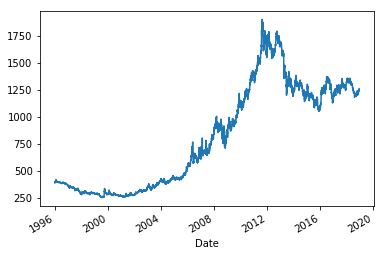

In [549]:
gold['Open'].plot()

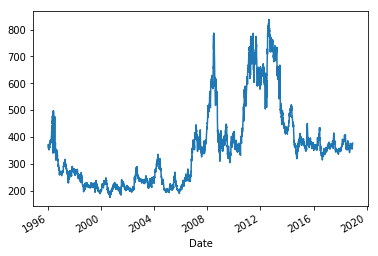

In [550]:
corn['Open'].plot()

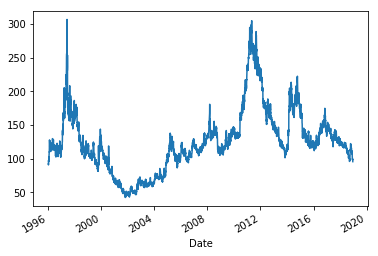

In [551]:
coffee['Open'].plot()

In [552]:
import numpy as np
import holidays

def trading_day_of_month(tm):
    ts = (tm - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
    dt = datetime.datetime.fromtimestamp(ts)
    di = datetime.date(year=dt.year, month=dt.month, day=1)
    us_holidays = holidays.UnitedStates()
    cnt = 1
    for i in range(1, 32):
        if i == dt.day:
            break
        if di.weekday() in [0, 1, 2, 3, 4] and dt not in us_holidays:
            cnt += 1
        di += datetime.timedelta(days=1)
    return cnt


def create_vectors(df, df_cot):
    global trading_days_in_year
    
    ans_dct = {}
    for i in range(df.shape[0]):
        if i < 2*trading_days_in_year:
            continue
        mtrx = df.iloc[i-2*trading_days_in_year:i, 0:(df.shape[1]-1)].values
        size = np.prod(mtrx.shape)
        mtrx = list(mtrx.reshape(size))
        idx = df.index.values[i]
        # add COT report to the end of list
        mtrx_cot = df_cot[df_cot.index < idx].values[-8:]
        size = np.prod(mtrx_cot.shape)
        mtrx_cot = list(mtrx_cot.reshape(size))
        if size < 16:
            mtrx_cot += [0 for i in range(16-size)]
        # Date Features
        # print(type(idx), type(idx.astype(datetime.datetime)))
        ts = (idx - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
        dt = datetime.datetime.fromtimestamp(ts)
        # wr = 
        mtrx_date = [dt.weekday(), trading_day_of_month(idx), dt.month, (dt.month-1)//3]
        # Combine list
        mtrx = mtrx + mtrx_cot + mtrx_date
        mtrx.append(df.iloc[i, df.shape[1]-1])
        ans_dct[idx] = mtrx
    return pd.DataFrame.from_dict(ans_dct, orient='index')

In [553]:
gold_data = create_vectors(gold, gold_cot)
gold_data = gold_data.loc[:end_date]
corn_data = create_vectors(corn, corn_cot)
corn_data = corn_data.loc[:end_date]
coffee_data = create_vectors(coffee, coffee_cot)
coffee_data = coffee_data.loc[:end_date]

In [554]:
gold_data.tail(20)

,0,1,2,3,4,5,6,7,8,9,...,3035,3036,3037,3038,3039,3040,3041,3042,3043,3044
2018-11-23,1213.5,1220.9,1205.6,1211.2,202123.0,199751.0,1212.6,1214.7,1181.2,1189.3,...,0.178079,0.942235,0.087364,0.916625,0.162104,4,17,11,3,0.0
2018-11-26,1212.6,1214.7,1181.2,1189.3,353644.0,164500.0,1189.4,1192.7,1170.3,1178.4,...,0.178079,0.942235,0.087364,0.916625,0.162104,0,18,11,3,-1.0
2018-11-27,1189.4,1192.7,1170.3,1178.4,288389.0,106069.0,1184.4,1197.2,1182.4,1190.8,...,0.178079,0.942235,0.087364,0.916625,0.162104,1,19,11,3,1.0
2018-11-28,1184.4,1197.2,1182.4,1190.8,177818.0,77556.0,1196.6,1197.7,1182.6,1190.8,...,0.087364,0.916625,0.162104,0.957183,0.139100,2,20,11,3,0.0
2018-11-29,1196.6,1197.7,1182.6,1190.8,196186.0,259190.0,1190.7,1196.8,1171.3,1173.9,...,0.087364,0.916625,0.162104,0.957183,0.139100,3,21,11,3,-1.0
2018-11-30,1190.7,1196.8,1171.3,1173.9,236195.0,271613.0,1175.1,1178.4,1162.2,1169.4,...,0.087364,0.916625,0.162104,0.957183,0.139100,4,22,11,3,1.0
2018-12-03,1175.1,1178.4,1162.2,1169.4,216866.0,273896.0,1174.3,1180.3,1168.4,1177.8,...,0.087364,0.916625,0.162104,0.957183,0.139100,0,1,12,3,1.0
2018-12-04,1174.3,1180.3,1168.4,1177.8,169593.0,273718.0,1182.6,1190.2,1158.6,1176.5,...,0.087364,0.916625,0.162104,0.957183,0.139100,1,2,12,3,0.0
2018-12-05,1182.6,1190.2,1158.6,1176.5,212507.0,275782.0,1172.8,1177.1,1168.1,1170.1,...,0.162104,0.957183,0.139100,0.859876,0.275776,2,3,12,3,0.0
2018-12-06,1172.8,1177.1,1168.1,1170.1,131034.0,271766.0,1171.4,1182.3,1167.2,1177.5,...,0.162104,0.957183,0.139100,0.859876,0.275776,3,4,12,3,1.0


In [555]:
gold_data.shape

(5276, 3045)

In [556]:
gold_cot.head(5)

,Prod_net_position_perc,Money_manager_net_position_perc
Date,,
2006-06-13,NaN,NaN
2006-06-20,1.000000,0.000000
2006-06-27,1.000000,0.000000
2006-07-03,0.919154,0.246529
2006-07-11,0.792600,1.000000


In [557]:
gold_data = gold_data[gold_data.index >= '2007-01-01']
corn_data = corn_data[corn_data.index >= '2007-01-01']
coffee_data = coffee_data[coffee_data.index >= '2007-01-01']

In [558]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


def data_split_pca_transform(df):
    label_index = 3044
    df_validate = df.loc['2016-01-01' <= df.index]
    df_data_tt = df.loc['2016-01-01' > df.index]
    df_train, df_test, label_train, label_test = train_test_split(df_data_tt[list(range(label_index))], df_data_tt[label_index], test_size=0.2, random_state=2242)

    pca_lst = []
    pca = PCA(n_components=3, random_state=2234)
    pca.fit(df_train[list(range(2016))])
    pca_lst.append(pca)
    
    pca = PCA(n_components=2, random_state=2233)
    pca.fit(df_train[list(range(2016, 2016 + 504))])
    pca_lst.append(pca)
    
    pca = PCA(n_components=2, random_state=2232)
    pca.fit(df_train[list(range(2016 + 504, 2016 + 1008))])
    pca_lst.append(pca)

    return df_train, df_test, label_train, label_test, df_validate[list(range(label_index))], df_data_tt[label_index], pca_lst


def pca_transform(df, pca_lst):
    label_index = 3044
    df_pca_lst = []
    df_pca = pca_lst[0].transform(df[list(range(2016))])
    df_pca_lst.append(df_pca)
    
    df_pca = pca_lst[1].transform(df[list(range(2016, 2016 + 504))])
    df_pca_lst.append(df_pca)
    
    df_pca = pca_lst[2].transform(df[list(range(2016 + 504, 2016 + 1008))])
    df_pca_lst.append(df_pca)
    
    df_pca = np.concatenate(df_pca_lst + [df[list(range(3025,label_index))].values], axis=1)
    return df_pca

In [559]:
gold_train, gold_test, gold_label_train, gold_label_test, gold_validate, gold_label_validate, gold_pca = data_split_pca_transform(gold_data)
corn_train, corn_test, corn_label_train, corn_label_test, corn_validate, corn_label_validate, corn_pca = data_split_pca_transform(corn_data)
coffee_train, coffee_test, coffee_label_train, coffee_label_test, coffee_validate, coffee_label_validate, coffee_pca = data_split_pca_transform(coffee_data)

In [560]:
gold_label_train.unique()

array([-1.,  0.,  1.])

In [561]:
import matplotlib.pyplot as plt


def plot_pca_relation(pca_data, label_train, x):
    labels = [0, 1, -1]
    labl={-1: 'Short', 0:'No Trade', 1:'Long'}
    plt.figure(1)

    for i in range(x):
        for j in range(i+1, x):
            fig, ax = plt.subplots(figsize=(7,5))
            fig.patch.set_facecolor('white')
            Xax = pca_data[:, i]
            Yax = pca_data[:, j]
            for l in labels:
                ix = np.where(label_train==l)
                ax.scatter(Xax[ix], Yax[ix], label=labl[l])

            plt.xlabel("Principal Component No " + str(i), fontsize=14)
            plt.ylabel("Second Principal Component No " + str(j), fontsize=14)
            plt.legend()
            plt.show()

In [562]:
pca_components = 3

<Figure size 432x288 with 0 Axes>

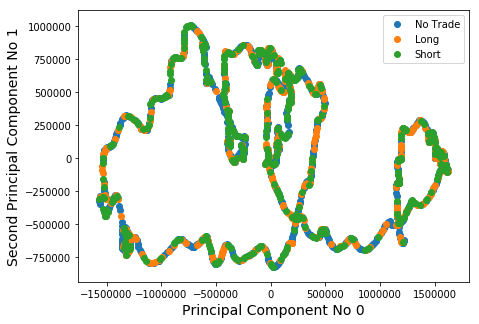

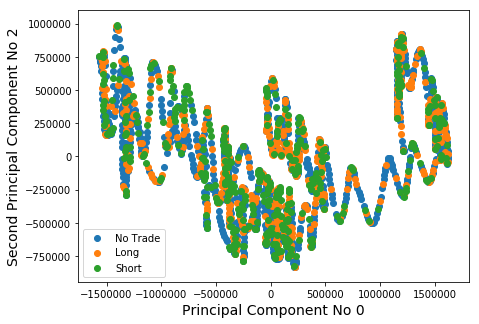

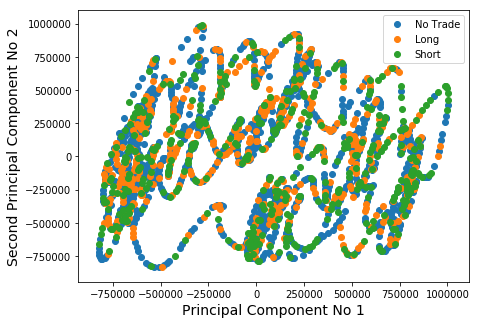

In [563]:
plot_pca_relation(gold_pca[0].transform(gold_train[list(range(2016))]), gold_label_train, pca_components)

<Figure size 432x288 with 0 Axes>

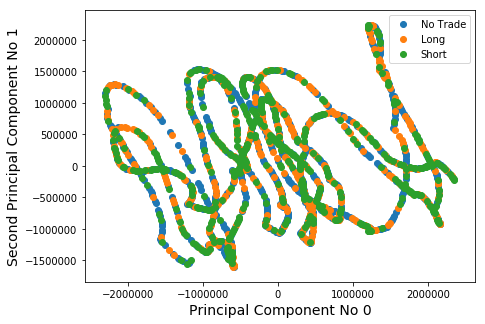

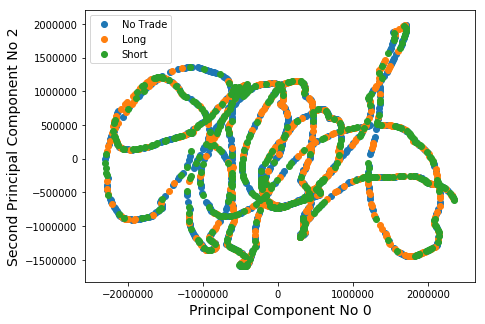

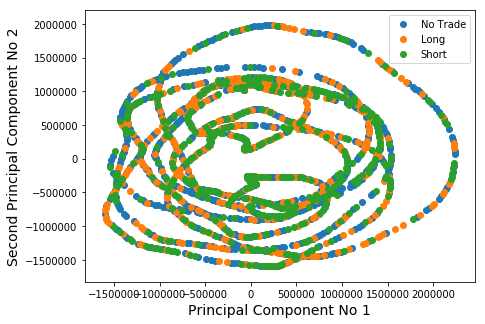

In [564]:
plot_pca_relation(corn_pca[0].transform(corn_train[list(range(2016))]), corn_label_train, pca_components)

<Figure size 432x288 with 0 Axes>

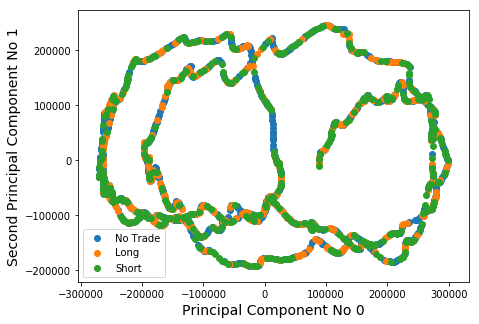

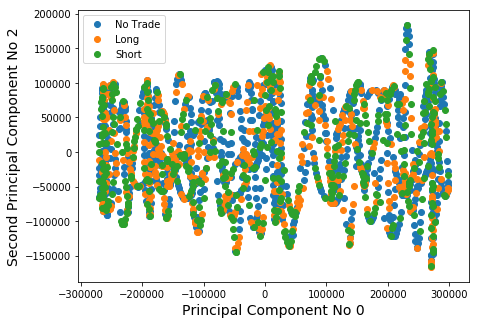

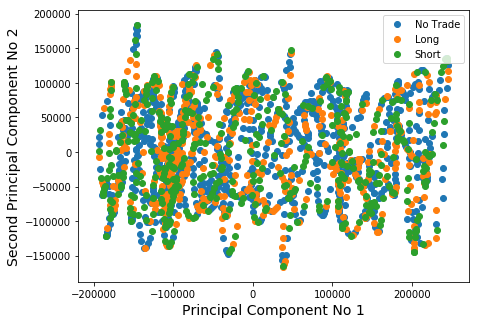

In [565]:
plot_pca_relation(coffee_pca[0].transform(coffee_train[list(range(2016))]), coffee_label_train, pca_components)

In [566]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
import lightgbm as lgb


X = pca_transform(gold_train, gold_pca)
train_data = lgb.Dataset(X, label=gold_label_train, categorical_feature=[3040,3041,3042,3043])
X_test = pca_transform(gold_test, gold_pca)
test_data = lgb.Dataset(X_test, label=gold_label_test)
param = {'num_leaves':31, 'objective':'binary'}
param['metric'] = 'auc'
param['metric'] = 'binary_logloss'
param['max_bin'] = 25
num_round = 1000
gold_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])
# gold_clf = RandomForestClassifier(n_estimators=150, random_state=1100)
# gold_clf = AdaBoostClassifier(n_estimators=100, random_state=1100, learning_rate=0.1)
# gold_clf = MLPClassifier(hidden_layer_sizes=(100, 3), solver='sgd', random_state=1100)
# gold_clf = MLPRegressor(hidden_layer_sizes=(100, 3), solver='sgd', max_iter=2000, alpha=0.1, random_state=1100)
# sample_weight = list(map(lambda x: 2 if x != 0 else 1, gold_label_train))
# gold_clf.fit(X, gold_label_train)
# gold_clf.fit(X, gold_label_train, sample_weight=sample_weight)

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [3040, 3041, 3042, 3043]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's binary_logloss: 0.709652
[2]	valid_0's binary_logloss: 0.674328
[3]	valid_0's binary_logloss: 0.650256
[4]	valid_0's binary_logloss: 0.635531
[5]	valid_0's binary_logloss: 0.627156
[6]	valid_0's binary_logloss: 0.623283
[7]	valid_0's binary_logloss: 0.622169
[8]	valid_0's binary_logloss: 0.619161
[9]	valid_0's binary_logloss: 0.616509
[10]	valid_0's binary_logloss: 0.616203
[11]	valid_0's binary_logloss: 0.614729
[12]	valid_0's binary_logloss: 0.615731
[13]	valid_0's binary_logloss: 0.61719
[14]	valid_0's binary_logloss: 0.620549
[15]	valid_0's binary_logloss: 0.62068
[16]	valid_0's binary_logloss: 0.62138
[17]	valid_0's binary_logloss: 0.6228
[18]	valid_0's binary_logloss: 0.621613
[19]	valid_0's binary_logloss: 0.624124
[20]	valid_0's binary_logloss: 0.624853
[21]	valid_0's binary_logloss: 0.62609
[22]	valid_0's binary_logloss: 0.629197
[23]	valid_0's binary_logloss: 0.631777
[24]	valid_0's binary_logloss: 0.632787
[25]	valid_0's binary_logloss: 0.635263
[26]	valid_0's 

[294]	valid_0's binary_logloss: 1.06408
[295]	valid_0's binary_logloss: 1.0648
[296]	valid_0's binary_logloss: 1.06684
[297]	valid_0's binary_logloss: 1.06944
[298]	valid_0's binary_logloss: 1.06949
[299]	valid_0's binary_logloss: 1.07092
[300]	valid_0's binary_logloss: 1.07241
[301]	valid_0's binary_logloss: 1.07472
[302]	valid_0's binary_logloss: 1.07531
[303]	valid_0's binary_logloss: 1.07697
[304]	valid_0's binary_logloss: 1.07969
[305]	valid_0's binary_logloss: 1.08162
[306]	valid_0's binary_logloss: 1.08284
[307]	valid_0's binary_logloss: 1.08421
[308]	valid_0's binary_logloss: 1.08657
[309]	valid_0's binary_logloss: 1.08934
[310]	valid_0's binary_logloss: 1.0916
[311]	valid_0's binary_logloss: 1.09333
[312]	valid_0's binary_logloss: 1.09461
[313]	valid_0's binary_logloss: 1.09579
[314]	valid_0's binary_logloss: 1.09684
[315]	valid_0's binary_logloss: 1.09725
[316]	valid_0's binary_logloss: 1.09803
[317]	valid_0's binary_logloss: 1.09939
[318]	valid_0's binary_logloss: 1.09968
[3

[583]	valid_0's binary_logloss: 1.47274
[584]	valid_0's binary_logloss: 1.4731
[585]	valid_0's binary_logloss: 1.47518
[586]	valid_0's binary_logloss: 1.47748
[587]	valid_0's binary_logloss: 1.4779
[588]	valid_0's binary_logloss: 1.47819
[589]	valid_0's binary_logloss: 1.48033
[590]	valid_0's binary_logloss: 1.48233
[591]	valid_0's binary_logloss: 1.48388
[592]	valid_0's binary_logloss: 1.48628
[593]	valid_0's binary_logloss: 1.48677
[594]	valid_0's binary_logloss: 1.48842
[595]	valid_0's binary_logloss: 1.4896
[596]	valid_0's binary_logloss: 1.49074
[597]	valid_0's binary_logloss: 1.49355
[598]	valid_0's binary_logloss: 1.49546
[599]	valid_0's binary_logloss: 1.49722
[600]	valid_0's binary_logloss: 1.49934
[601]	valid_0's binary_logloss: 1.50009
[602]	valid_0's binary_logloss: 1.50145
[603]	valid_0's binary_logloss: 1.50261
[604]	valid_0's binary_logloss: 1.50407
[605]	valid_0's binary_logloss: 1.50397
[606]	valid_0's binary_logloss: 1.50483
[607]	valid_0's binary_logloss: 1.50627
[60

[871]	valid_0's binary_logloss: 1.87781
[872]	valid_0's binary_logloss: 1.87833
[873]	valid_0's binary_logloss: 1.87967
[874]	valid_0's binary_logloss: 1.88002
[875]	valid_0's binary_logloss: 1.88104
[876]	valid_0's binary_logloss: 1.88274
[877]	valid_0's binary_logloss: 1.88482
[878]	valid_0's binary_logloss: 1.88815
[879]	valid_0's binary_logloss: 1.89022
[880]	valid_0's binary_logloss: 1.89229
[881]	valid_0's binary_logloss: 1.89379
[882]	valid_0's binary_logloss: 1.89315
[883]	valid_0's binary_logloss: 1.89379
[884]	valid_0's binary_logloss: 1.89505
[885]	valid_0's binary_logloss: 1.89608
[886]	valid_0's binary_logloss: 1.89814
[887]	valid_0's binary_logloss: 1.89956
[888]	valid_0's binary_logloss: 1.90087
[889]	valid_0's binary_logloss: 1.90256
[890]	valid_0's binary_logloss: 1.903
[891]	valid_0's binary_logloss: 1.90461
[892]	valid_0's binary_logloss: 1.9053
[893]	valid_0's binary_logloss: 1.90681
[894]	valid_0's binary_logloss: 1.9092
[895]	valid_0's binary_logloss: 1.91113
[896

In [567]:
X_test = pca_transform(gold_test, gold_pca)

# gold_clf.score(X_test, gold_label_test)

In [620]:
X = pca_transform(corn_train, corn_pca)
train_data = lgb.Dataset(X, label=corn_label_train, categorical_feature=[3040,3041,3042,3043])
X_test = pca_transform(corn_test, corn_pca)
test_data = lgb.Dataset(X_test, label=corn_label_test)
param = {'num_leaves':31, 'objective':'binary'}
# param['metric'] = 'auc'
param['metric'] = 'binary_logloss'
param['max_bin'] = 50
num_round = 2000
corn_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

# corn_clf = AdaBoostClassifier(n_estimators=150, learning_rate=0.25, random_state=1100)
# corn_clf = RandomForestClassifier(n_estimators=100, random_state=1100)
# sample_weight = list(map(lambda x: 2 if x != 0 else 1, corn_label_train))
# corn_clf.fit(X, corn_label_train)

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [3040, 3041, 3042, 3043]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's binary_logloss: 0.73953
[2]	valid_0's binary_logloss: 0.687354
[3]	valid_0's binary_logloss: 0.65562
[4]	valid_0's binary_logloss: 0.636034
[5]	valid_0's binary_logloss: 0.623883
[6]	valid_0's binary_logloss: 0.615723
[7]	valid_0's binary_logloss: 0.608245
[8]	valid_0's binary_logloss: 0.603209
[9]	valid_0's binary_logloss: 0.604455
[10]	valid_0's binary_logloss: 0.60312
[11]	valid_0's binary_logloss: 0.601716
[12]	valid_0's binary_logloss: 0.601741
[13]	valid_0's binary_logloss: 0.600457
[14]	valid_0's binary_logloss: 0.604244
[15]	valid_0's binary_logloss: 0.605432
[16]	valid_0's binary_logloss: 0.606086
[17]	valid_0's binary_logloss: 0.605323
[18]	valid_0's binary_logloss: 0.605509
[19]	valid_0's binary_logloss: 0.605226
[20]	valid_0's binary_logloss: 0.605358
[21]	valid_0's binary_logloss: 0.606826
[22]	valid_0's binary_logloss: 0.605902
[23]	valid_0's binary_logloss: 0.606166
[24]	valid_0's binary_logloss: 0.605223
[25]	valid_0's binary_logloss: 0.606597
[26]	valid_0

[265]	valid_0's binary_logloss: 0.828282
[266]	valid_0's binary_logloss: 0.829425
[267]	valid_0's binary_logloss: 0.831205
[268]	valid_0's binary_logloss: 0.831275
[269]	valid_0's binary_logloss: 0.831594
[270]	valid_0's binary_logloss: 0.831163
[271]	valid_0's binary_logloss: 0.832094
[272]	valid_0's binary_logloss: 0.833822
[273]	valid_0's binary_logloss: 0.833572
[274]	valid_0's binary_logloss: 0.834389
[275]	valid_0's binary_logloss: 0.834869
[276]	valid_0's binary_logloss: 0.835779
[277]	valid_0's binary_logloss: 0.83602
[278]	valid_0's binary_logloss: 0.836156
[279]	valid_0's binary_logloss: 0.836702
[280]	valid_0's binary_logloss: 0.838191
[281]	valid_0's binary_logloss: 0.839803
[282]	valid_0's binary_logloss: 0.840598
[283]	valid_0's binary_logloss: 0.841435
[284]	valid_0's binary_logloss: 0.842853
[285]	valid_0's binary_logloss: 0.843672
[286]	valid_0's binary_logloss: 0.84515
[287]	valid_0's binary_logloss: 0.845587
[288]	valid_0's binary_logloss: 0.847999
[289]	valid_0's bi

[531]	valid_0's binary_logloss: 1.09712
[532]	valid_0's binary_logloss: 1.09858
[533]	valid_0's binary_logloss: 1.09947
[534]	valid_0's binary_logloss: 1.09953
[535]	valid_0's binary_logloss: 1.10057
[536]	valid_0's binary_logloss: 1.10141
[537]	valid_0's binary_logloss: 1.10405
[538]	valid_0's binary_logloss: 1.1048
[539]	valid_0's binary_logloss: 1.10646
[540]	valid_0's binary_logloss: 1.10794
[541]	valid_0's binary_logloss: 1.10878
[542]	valid_0's binary_logloss: 1.1104
[543]	valid_0's binary_logloss: 1.111
[544]	valid_0's binary_logloss: 1.11197
[545]	valid_0's binary_logloss: 1.11229
[546]	valid_0's binary_logloss: 1.11388
[547]	valid_0's binary_logloss: 1.11519
[548]	valid_0's binary_logloss: 1.11654
[549]	valid_0's binary_logloss: 1.1174
[550]	valid_0's binary_logloss: 1.11934
[551]	valid_0's binary_logloss: 1.12014
[552]	valid_0's binary_logloss: 1.12131
[553]	valid_0's binary_logloss: 1.12236
[554]	valid_0's binary_logloss: 1.12278
[555]	valid_0's binary_logloss: 1.12444
[556]

[780]	valid_0's binary_logloss: 1.37425
[781]	valid_0's binary_logloss: 1.3757
[782]	valid_0's binary_logloss: 1.37733
[783]	valid_0's binary_logloss: 1.37809
[784]	valid_0's binary_logloss: 1.379
[785]	valid_0's binary_logloss: 1.37982
[786]	valid_0's binary_logloss: 1.38085
[787]	valid_0's binary_logloss: 1.38283
[788]	valid_0's binary_logloss: 1.38434
[789]	valid_0's binary_logloss: 1.3859
[790]	valid_0's binary_logloss: 1.38651
[791]	valid_0's binary_logloss: 1.38735
[792]	valid_0's binary_logloss: 1.38863
[793]	valid_0's binary_logloss: 1.38996
[794]	valid_0's binary_logloss: 1.39172
[795]	valid_0's binary_logloss: 1.39287
[796]	valid_0's binary_logloss: 1.39374
[797]	valid_0's binary_logloss: 1.39453
[798]	valid_0's binary_logloss: 1.39369
[799]	valid_0's binary_logloss: 1.39442
[800]	valid_0's binary_logloss: 1.3943
[801]	valid_0's binary_logloss: 1.39527
[802]	valid_0's binary_logloss: 1.39658
[803]	valid_0's binary_logloss: 1.39756
[804]	valid_0's binary_logloss: 1.39859
[805]

[1048]	valid_0's binary_logloss: 1.64318
[1049]	valid_0's binary_logloss: 1.64468
[1050]	valid_0's binary_logloss: 1.64628
[1051]	valid_0's binary_logloss: 1.64758
[1052]	valid_0's binary_logloss: 1.64956
[1053]	valid_0's binary_logloss: 1.65012
[1054]	valid_0's binary_logloss: 1.65047
[1055]	valid_0's binary_logloss: 1.65121
[1056]	valid_0's binary_logloss: 1.6528
[1057]	valid_0's binary_logloss: 1.65445
[1058]	valid_0's binary_logloss: 1.6561
[1059]	valid_0's binary_logloss: 1.6577
[1060]	valid_0's binary_logloss: 1.65809
[1061]	valid_0's binary_logloss: 1.65787
[1062]	valid_0's binary_logloss: 1.65906
[1063]	valid_0's binary_logloss: 1.65905
[1064]	valid_0's binary_logloss: 1.65966
[1065]	valid_0's binary_logloss: 1.66172
[1066]	valid_0's binary_logloss: 1.66258
[1067]	valid_0's binary_logloss: 1.66293
[1068]	valid_0's binary_logloss: 1.66348
[1069]	valid_0's binary_logloss: 1.66505
[1070]	valid_0's binary_logloss: 1.66604
[1071]	valid_0's binary_logloss: 1.66731
[1072]	valid_0's bi

[1291]	valid_0's binary_logloss: 1.91294
[1292]	valid_0's binary_logloss: 1.91536
[1293]	valid_0's binary_logloss: 1.91596
[1294]	valid_0's binary_logloss: 1.91682
[1295]	valid_0's binary_logloss: 1.91824
[1296]	valid_0's binary_logloss: 1.91879
[1297]	valid_0's binary_logloss: 1.92024
[1298]	valid_0's binary_logloss: 1.92167
[1299]	valid_0's binary_logloss: 1.92413
[1300]	valid_0's binary_logloss: 1.92553
[1301]	valid_0's binary_logloss: 1.92631
[1302]	valid_0's binary_logloss: 1.92858
[1303]	valid_0's binary_logloss: 1.9288
[1304]	valid_0's binary_logloss: 1.92938
[1305]	valid_0's binary_logloss: 1.92985
[1306]	valid_0's binary_logloss: 1.9304
[1307]	valid_0's binary_logloss: 1.93218
[1308]	valid_0's binary_logloss: 1.93241
[1309]	valid_0's binary_logloss: 1.9333
[1310]	valid_0's binary_logloss: 1.93604
[1311]	valid_0's binary_logloss: 1.93611
[1312]	valid_0's binary_logloss: 1.93663
[1313]	valid_0's binary_logloss: 1.9383
[1314]	valid_0's binary_logloss: 1.93724
[1315]	valid_0's bin

[1577]	valid_0's binary_logloss: 2.22
[1578]	valid_0's binary_logloss: 2.22112
[1579]	valid_0's binary_logloss: 2.22197
[1580]	valid_0's binary_logloss: 2.22373
[1581]	valid_0's binary_logloss: 2.22435
[1582]	valid_0's binary_logloss: 2.22503
[1583]	valid_0's binary_logloss: 2.22593
[1584]	valid_0's binary_logloss: 2.22774
[1585]	valid_0's binary_logloss: 2.22803
[1586]	valid_0's binary_logloss: 2.22895
[1587]	valid_0's binary_logloss: 2.2292
[1588]	valid_0's binary_logloss: 2.23044
[1589]	valid_0's binary_logloss: 2.23112
[1590]	valid_0's binary_logloss: 2.23175
[1591]	valid_0's binary_logloss: 2.23463
[1592]	valid_0's binary_logloss: 2.23639
[1593]	valid_0's binary_logloss: 2.23728
[1594]	valid_0's binary_logloss: 2.23809
[1595]	valid_0's binary_logloss: 2.2397
[1596]	valid_0's binary_logloss: 2.24023
[1597]	valid_0's binary_logloss: 2.24156
[1598]	valid_0's binary_logloss: 2.24207
[1599]	valid_0's binary_logloss: 2.24335
[1600]	valid_0's binary_logloss: 2.24361
[1601]	valid_0's bina

[1820]	valid_0's binary_logloss: 2.46699
[1821]	valid_0's binary_logloss: 2.46781
[1822]	valid_0's binary_logloss: 2.46942
[1823]	valid_0's binary_logloss: 2.47015
[1824]	valid_0's binary_logloss: 2.47123
[1825]	valid_0's binary_logloss: 2.47138
[1826]	valid_0's binary_logloss: 2.47178
[1827]	valid_0's binary_logloss: 2.47369
[1828]	valid_0's binary_logloss: 2.47476
[1829]	valid_0's binary_logloss: 2.47615
[1830]	valid_0's binary_logloss: 2.47699
[1831]	valid_0's binary_logloss: 2.47892
[1832]	valid_0's binary_logloss: 2.47985
[1833]	valid_0's binary_logloss: 2.48064
[1834]	valid_0's binary_logloss: 2.48126
[1835]	valid_0's binary_logloss: 2.48199
[1836]	valid_0's binary_logloss: 2.48203
[1837]	valid_0's binary_logloss: 2.4825
[1838]	valid_0's binary_logloss: 2.48282
[1839]	valid_0's binary_logloss: 2.48312
[1840]	valid_0's binary_logloss: 2.48438
[1841]	valid_0's binary_logloss: 2.48459
[1842]	valid_0's binary_logloss: 2.48588
[1843]	valid_0's binary_logloss: 2.4882
[1844]	valid_0's b

In [627]:
X = pca_transform(coffee_train, coffee_pca)
train_data = lgb.Dataset(X, label=coffee_label_train, categorical_feature=[3040,3041,3042,3043])
X_test = pca_transform(coffee_test, coffee_pca)
test_data = lgb.Dataset(X_test, label=coffee_label_test)
param = {'num_leaves':31, 'objective':'binary'}
# param['metric'] = 'auc'
param['metric'] = 'binary_logloss'
param['max_bin'] = 50
num_round = 2000
coffee_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

# coffee_clf = AdaBoostClassifier(n_estimators=150, learning_rate=0.5, random_state=1100)
# # coffee_clf = RandomForestClassifier(n_estimators=100, random_state=1100)
# sample_weight = list(map(lambda x: 2 if x != 0 else 1, coffee_label_train))
# coffee_clf.fit(X, coffee_label_train)

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [3040, 3041, 3042, 3043]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's binary_logloss: 0.795502
[2]	valid_0's binary_logloss: 0.750633
[3]	valid_0's binary_logloss: 0.727995
[4]	valid_0's binary_logloss: 0.708935
[5]	valid_0's binary_logloss: 0.697994
[6]	valid_0's binary_logloss: 0.691434
[7]	valid_0's binary_logloss: 0.68351
[8]	valid_0's binary_logloss: 0.677554
[9]	valid_0's binary_logloss: 0.675243
[10]	valid_0's binary_logloss: 0.672951
[11]	valid_0's binary_logloss: 0.670766
[12]	valid_0's binary_logloss: 0.666423
[13]	valid_0's binary_logloss: 0.663502
[14]	valid_0's binary_logloss: 0.662356
[15]	valid_0's binary_logloss: 0.660386
[16]	valid_0's binary_logloss: 0.658898
[17]	valid_0's binary_logloss: 0.657318
[18]	valid_0's binary_logloss: 0.656208
[19]	valid_0's binary_logloss: 0.656471
[20]	valid_0's binary_logloss: 0.657698
[21]	valid_0's binary_logloss: 0.657669
[22]	valid_0's binary_logloss: 0.65871
[23]	valid_0's binary_logloss: 0.661882
[24]	valid_0's binary_logloss: 0.664066
[25]	valid_0's binary_logloss: 0.66492
[26]	valid_0

[425]	valid_0's binary_logloss: 1.16168
[426]	valid_0's binary_logloss: 1.16308
[427]	valid_0's binary_logloss: 1.1639
[428]	valid_0's binary_logloss: 1.16607
[429]	valid_0's binary_logloss: 1.16713
[430]	valid_0's binary_logloss: 1.168
[431]	valid_0's binary_logloss: 1.1706
[432]	valid_0's binary_logloss: 1.17269
[433]	valid_0's binary_logloss: 1.17323
[434]	valid_0's binary_logloss: 1.17531
[435]	valid_0's binary_logloss: 1.17689
[436]	valid_0's binary_logloss: 1.17783
[437]	valid_0's binary_logloss: 1.18071
[438]	valid_0's binary_logloss: 1.18065
[439]	valid_0's binary_logloss: 1.1813
[440]	valid_0's binary_logloss: 1.18244
[441]	valid_0's binary_logloss: 1.18381
[442]	valid_0's binary_logloss: 1.18637
[443]	valid_0's binary_logloss: 1.18799
[444]	valid_0's binary_logloss: 1.18915
[445]	valid_0's binary_logloss: 1.18963
[446]	valid_0's binary_logloss: 1.19106
[447]	valid_0's binary_logloss: 1.19141
[448]	valid_0's binary_logloss: 1.19307
[449]	valid_0's binary_logloss: 1.19331
[450]

[693]	valid_0's binary_logloss: 1.51488
[694]	valid_0's binary_logloss: 1.51653
[695]	valid_0's binary_logloss: 1.51649
[696]	valid_0's binary_logloss: 1.51724
[697]	valid_0's binary_logloss: 1.51809
[698]	valid_0's binary_logloss: 1.51983
[699]	valid_0's binary_logloss: 1.52127
[700]	valid_0's binary_logloss: 1.52126
[701]	valid_0's binary_logloss: 1.52255
[702]	valid_0's binary_logloss: 1.52315
[703]	valid_0's binary_logloss: 1.52476
[704]	valid_0's binary_logloss: 1.52664
[705]	valid_0's binary_logloss: 1.52816
[706]	valid_0's binary_logloss: 1.52985
[707]	valid_0's binary_logloss: 1.53091
[708]	valid_0's binary_logloss: 1.53267
[709]	valid_0's binary_logloss: 1.53455
[710]	valid_0's binary_logloss: 1.53717
[711]	valid_0's binary_logloss: 1.53809
[712]	valid_0's binary_logloss: 1.54065
[713]	valid_0's binary_logloss: 1.54243
[714]	valid_0's binary_logloss: 1.54301
[715]	valid_0's binary_logloss: 1.54356
[716]	valid_0's binary_logloss: 1.54417
[717]	valid_0's binary_logloss: 1.5468
[

[957]	valid_0's binary_logloss: 1.85703
[958]	valid_0's binary_logloss: 1.85881
[959]	valid_0's binary_logloss: 1.86013
[960]	valid_0's binary_logloss: 1.86128
[961]	valid_0's binary_logloss: 1.86185
[962]	valid_0's binary_logloss: 1.86315
[963]	valid_0's binary_logloss: 1.86485
[964]	valid_0's binary_logloss: 1.86609
[965]	valid_0's binary_logloss: 1.86729
[966]	valid_0's binary_logloss: 1.86844
[967]	valid_0's binary_logloss: 1.8693
[968]	valid_0's binary_logloss: 1.87102
[969]	valid_0's binary_logloss: 1.87181
[970]	valid_0's binary_logloss: 1.87325
[971]	valid_0's binary_logloss: 1.8757
[972]	valid_0's binary_logloss: 1.87775
[973]	valid_0's binary_logloss: 1.87991
[974]	valid_0's binary_logloss: 1.88034
[975]	valid_0's binary_logloss: 1.88331
[976]	valid_0's binary_logloss: 1.88453
[977]	valid_0's binary_logloss: 1.8865
[978]	valid_0's binary_logloss: 1.88849
[979]	valid_0's binary_logloss: 1.88898
[980]	valid_0's binary_logloss: 1.89027
[981]	valid_0's binary_logloss: 1.89185
[98

[1421]	valid_0's binary_logloss: 2.49062
[1422]	valid_0's binary_logloss: 2.49333
[1423]	valid_0's binary_logloss: 2.49424
[1424]	valid_0's binary_logloss: 2.49447
[1425]	valid_0's binary_logloss: 2.49499
[1426]	valid_0's binary_logloss: 2.49654
[1427]	valid_0's binary_logloss: 2.49775
[1428]	valid_0's binary_logloss: 2.49918
[1429]	valid_0's binary_logloss: 2.50081
[1430]	valid_0's binary_logloss: 2.5025
[1431]	valid_0's binary_logloss: 2.50351
[1432]	valid_0's binary_logloss: 2.50441
[1433]	valid_0's binary_logloss: 2.50571
[1434]	valid_0's binary_logloss: 2.50691
[1435]	valid_0's binary_logloss: 2.50664
[1436]	valid_0's binary_logloss: 2.50853
[1437]	valid_0's binary_logloss: 2.50907
[1438]	valid_0's binary_logloss: 2.51111
[1439]	valid_0's binary_logloss: 2.51171
[1440]	valid_0's binary_logloss: 2.51428
[1441]	valid_0's binary_logloss: 2.51624
[1442]	valid_0's binary_logloss: 2.5173
[1443]	valid_0's binary_logloss: 2.51857
[1444]	valid_0's binary_logloss: 2.52039
[1445]	valid_0's b

[1672]	valid_0's binary_logloss: 2.77936
[1673]	valid_0's binary_logloss: 2.78052
[1674]	valid_0's binary_logloss: 2.78193
[1675]	valid_0's binary_logloss: 2.78243
[1676]	valid_0's binary_logloss: 2.78383
[1677]	valid_0's binary_logloss: 2.78484
[1678]	valid_0's binary_logloss: 2.78594
[1679]	valid_0's binary_logloss: 2.78751
[1680]	valid_0's binary_logloss: 2.78899
[1681]	valid_0's binary_logloss: 2.7893
[1682]	valid_0's binary_logloss: 2.79071
[1683]	valid_0's binary_logloss: 2.79214
[1684]	valid_0's binary_logloss: 2.79312
[1685]	valid_0's binary_logloss: 2.79373
[1686]	valid_0's binary_logloss: 2.79416
[1687]	valid_0's binary_logloss: 2.79504
[1688]	valid_0's binary_logloss: 2.79634
[1689]	valid_0's binary_logloss: 2.79771
[1690]	valid_0's binary_logloss: 2.79781
[1691]	valid_0's binary_logloss: 2.79847
[1692]	valid_0's binary_logloss: 2.79955
[1693]	valid_0's binary_logloss: 2.80023
[1694]	valid_0's binary_logloss: 2.801
[1695]	valid_0's binary_logloss: 2.80199
[1696]	valid_0's bi

[1947]	valid_0's binary_logloss: 2.94899
[1948]	valid_0's binary_logloss: 2.94933
[1949]	valid_0's binary_logloss: 2.94982
[1950]	valid_0's binary_logloss: 2.94959
[1951]	valid_0's binary_logloss: 2.94995
[1952]	valid_0's binary_logloss: 2.95061
[1953]	valid_0's binary_logloss: 2.95098
[1954]	valid_0's binary_logloss: 2.95059
[1955]	valid_0's binary_logloss: 2.95072
[1956]	valid_0's binary_logloss: 2.95163
[1957]	valid_0's binary_logloss: 2.95248
[1958]	valid_0's binary_logloss: 2.95322
[1959]	valid_0's binary_logloss: 2.95366
[1960]	valid_0's binary_logloss: 2.95381
[1961]	valid_0's binary_logloss: 2.95372
[1962]	valid_0's binary_logloss: 2.95395
[1963]	valid_0's binary_logloss: 2.95485
[1964]	valid_0's binary_logloss: 2.95488
[1965]	valid_0's binary_logloss: 2.95545
[1966]	valid_0's binary_logloss: 2.95593
[1967]	valid_0's binary_logloss: 2.95662
[1968]	valid_0's binary_logloss: 2.95624
[1969]	valid_0's binary_logloss: 2.95717
[1970]	valid_0's binary_logloss: 2.95807
[1971]	valid_0's

In [628]:
# X_test = pca_transform(corn_test, corn_pca)
# corn_clf.score(X_test, corn_label_test)

In [629]:
def get_performance(model, pca, df_gains, df, labels):
    global account_size, fee, stop_loss
    acc = account_size
    df = pca_transform(df, pca)
    predictions = model.predict(df)
    # print(predictions)
    dct = {}
    dct['account'] = [acc]
    for p, l, v in zip(predictions, labels, df_gains.values):
        if p > 0.5:
            if (v[1] - v[3]) > stop_loss:
                acc -= stop_loss
            else:
                acc += v[0] - fee
        elif p < -0.5:
            if (v[2] - v[1]) > stop_loss:
                acc -= stop_loss
            else:
                acc -= v[0] - fee
        dct['account'].append(acc)
        if acc <= 0:
            break
    return pd.DataFrame.from_dict(dct)

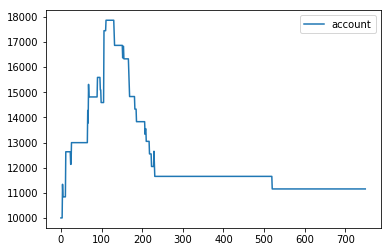

In [630]:
gold_account = get_performance(gold_clf, gold_pca, gold_gains[gold_gains.index > '2016-01-01'], gold_validate, gold_label_validate)
gold_account.plot()

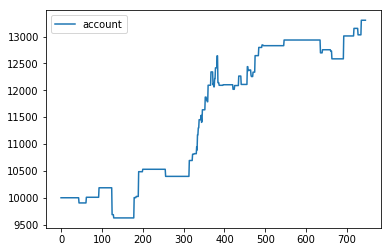

In [631]:
corn_account = get_performance(corn_clf, corn_pca, corn_gains[corn_gains.index > '2016-01-01'], corn_validate, corn_label_validate)
corn_account.plot()

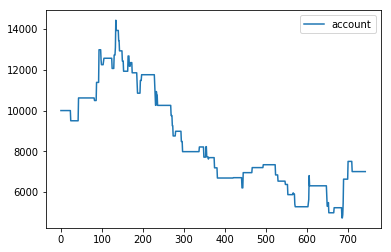

In [632]:
coffee_account = get_performance(coffee_clf, coffee_pca, coffee_gains[coffee_gains.index > '2016-01-01'], coffee_validate, coffee_label_validate)
coffee_account.plot()